## Load available keys

In [1]:
import ooiod

In [2]:
key_file = '/home/jovyan/repos/ooi-opendata/secrets/daxsoule.pickle'
keys = ooiod.secrets.load_keys(key_file)

You have:
    botpt


## Download a NetCDF file from OOI results server

In [3]:
netcdf_url = 'https://opendap.oceanobservatories.org/async_results/dax.soule@qc.cuny.edu/20191104T001715257Z-RS03INT2-MJ03D-06-BOTPTA303-streamed-botpt_nano_sample/deployment0001_RS03INT2-MJ03D-06-BOTPTA303-streamed-botpt_nano_sample_20150102T205959.900000-20150110T210000.100000.nc'
netcdf_filename = netcdf_url.split('/')[-1]

In [4]:
import wget

In [5]:
wget.download(netcdf_url);

## Write the original NetCDF file into Azure blob

In [6]:
from azure.storage.blob import BlockBlobService

In [7]:
if 'botpt' in keys:
    botpt_service = BlockBlobService('ooiopendata', sas_token = keys['botpt'])
else:
    raise Exception('Botpt container key not available')

In [5]:
botpt_service.create_blob_from_path('botpt', netcdf_filename, netcdf_filename, validate_content=True);

NameError: name 'botpt_service' is not defined

In [4]:
for blob in botpt_service.list_blobs('botpt'):
    print(blob.name)

NameError: name 'botpt_service' is not defined

## Load the file into Xarray and save to ooiopendata

In [7]:
import xarray as xr
import zarr
import logging
logging.getLogger("azure.storage").setLevel(logging.CRITICAL)

In [22]:
ds = xr.open_dataset(netcdf_filename)
ds = ds.swap_dims({'obs': 'time'})
ds

<xarray.Dataset>
Dimensions:                      (time: 13786091)
Coordinates:
    obs                          (time) int32 0 1 2 ... 13786089 13786090
  * time                         (time) datetime64[ns] 2015-01-02T20:59:59.900000256 ... 2015-01-10T21:00:00.099999744
Data variables:
    deployment                   (time) int32 ...
    id                           (time) |S36 ...
    bottom_pressure              (time) float32 ...
    date_time_string             (time) object ...
    driver_timestamp             (time) datetime64[ns] ...
    ingestion_timestamp          (time) datetime64[ns] ...
    internal_timestamp           (time) datetime64[ns] ...
    port_timestamp               (time) datetime64[ns] ...
    preferred_timestamp          (time) object ...
    press_trans_temp             (time) float64 ...
    provenance                   (time) |S1 ...
    sensor_id                    (time) object ...
    time_sync_flag               (time) object ...
    bottom_pressure_qc_executed  (time) uint8 ...
    bottom_pressure_qc_results   (time) uint8 ...
Attributes:
    node:                               MJ03D
    comment:                            
    publisher_email:                    
    sourceUrl:                          http://oceanobservatories.org/
    collection_method:                  streamed
    stream:                             botpt_nano_sample
    featureType:                        point
    creator_email:                      
    publisher_name:                     Ocean Observatories Initiative
    date_modified:                      2019-11-04T07:40:15.069905
    keywords:                           
    cdm_data_type:                      Point
    references:                         More information can be found at http...
    Metadata_Conventions:               Unidata Dataset Discovery v1.0
    date_created:                       2019-11-04T07:40:15.069900
    id:                                 RS03INT2-MJ03D-06-BOTPTA303-streamed-...
    requestUUID:                        e7cba928-5838-429e-8276-fd60651f4659
    contributor_role:                   
    summary:                            Dataset Generated by Stream Engine fr...
    keywords_vocabulary:                
    institution:                        Ocean Observatories Initiative
    naming_authority:                   org.oceanobservatories
    feature_Type:                       point
    infoUrl:                            http://oceanobservatories.org/
    license:                            
    contributor_name:                   
    uuid:                               e7cba928-5838-429e-8276-fd60651f4659
    creator_name:                       Ocean Observatories Initiative
    title:                              Data produced by Stream Engine versio...
    sensor:                             06-BOTPTA303
    standard_name_vocabulary:           NetCDF Climate and Forecast (CF) Meta...
    acknowledgement:                    
    Conventions:                        CF-1.6
    project:                            Ocean Observatories Initiative
    source:                             RS03INT2-MJ03D-06-BOTPTA303-streamed-...
    publisher_url:                      http://oceanobservatories.org/
    creator_url:                        http://oceanobservatories.org/
    nodc_template_version:              NODC_NetCDF_TimeSeries_Orthogonal_Tem...
    subsite:                            RS03INT2
    processing_level:                   L2
    history:                            2019-11-04T07:40:15.069843 generated ...
    Manufacturer:                       NOAA-PMEL
    ModelNumber:                        Custom
    SerialNumber:                       4
    Description:                        Bottom Pressure and Tilt: BOTPT Series A
    FirmwareVersion:                    Not specified.
    SoftwareVersion:                    Not specified.
    AssetUniqueID:                      ATAPL-58316-00002
    Notes:                    

In [23]:
ds.data_vars

Data variables:
    deployment                   (time) int32 ...
    id                           (time) |S36 ...
    bottom_pressure              (time) float32 ...
    date_time_string             (time) object ...
    driver_timestamp             (time) datetime64[ns] ...
    ingestion_timestamp          (time) datetime64[ns] ...
    internal_timestamp           (time) datetime64[ns] ...
    port_timestamp               (time) datetime64[ns] ...
    preferred_timestamp          (time) object ...
    press_trans_temp             (time) float64 ...
    provenance                   (time) |S1 ...
    sensor_id                    (time) object ...
    time_sync_flag               (time) object ...
    bottom_pressure_qc_executed  (time) uint8 ...
    bottom_pressure_qc_results   (time) uint8 ...

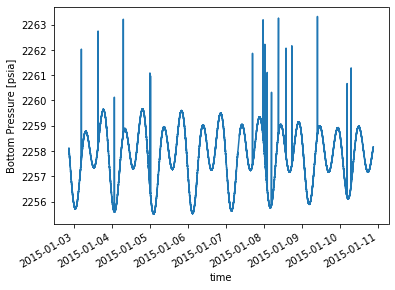

In [24]:
ds['bottom_pressure'].plot()

In [25]:
ds.source

'RS03INT2-MJ03D-06-BOTPTA303-streamed-botpt_nano_sample'

In [26]:
'%s-%s-%s' % (ds.subsite,ds.node,ds.sensor)

'RS03INT2-MJ03D-06-BOTPTA303'

In [27]:
ds['press_trans_temp']

<xarray.DataArray 'press_trans_temp' (time: 13786091)>
[13786091 values with dtype=float64]
Coordinates:
    obs      (time) int32 0 1 2 3 4 ... 13786087 13786088 13786089 13786090
  * time     (time) datetime64[ns] 2015-01-02T20:59:59.900000256 ... 2015-01-10T21:00:00.099999744
Attributes:
    comment:                  Nano-resolution Pressure Transducer Temperature...
    long_name:                Nano-Resolution Pressure Transducer Temperature
    coordinates:              time lat lon
    data_product_identifier:  NPTTEMP
    units:                    ºC

In [29]:
import textwrap
textwrap.wrap(ds['press_trans_temp'].comment)

['Nano-resolution Pressure Transducer Temperature is the internal',
 'transducer temperature that is used for onboard temperature-',
 'compensation of the pressure measurements produced by the BOTPT',
 'instrument.']

In [30]:
ds['bottom_pressure'].dims

('time',)